# Time series prediction (Part 2)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## Prediction models

### ARIMA

#### Theory behind

Le modèle ARMA (AutoRegressive Moving Average) ou ARMA (autorégressifs et moyenne mobile) en français, est un modèle adapté au prédiction sur toute série temporelle dont la valeur $Y$ à l'instant $t$ peut s'expliquer par les valeurs précédentes et les perturbations (bruits) précédentes.

Avant de préciser ce qu'est un jeu de donnée suivant le modèle ARIMA, précisons un jeu de donnée suivant les conditions :  

- **Autoregressif** : le modèle prédit la variable $Y$ à l'instant $t$, notée $Y_t$, à partir des valeurs précédentes de $Y$ selon un modèle de regression linéaire, c'est à dire $Y_{t-1}, Y_{t-2}, ..., Y_0$. On note $p$ le nombre de composantes utilisées pour prédire $Y_t$, avec

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, avec $\varepsilon_t$ une perturbation, et c une constante.

- **Moyenne mobile**: un modèle où les données sont le résultat de la moyenne mobile d'ordre $q$. Il est possible d'exprimer la valeur $Y_t$ à l'aide de la perturbation à l'instant $t$ et ses valeurs précédentes :

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, avec $\mu$ une constante.

Tout jeu de données ARIMA est la combinaison des conditions *AR* et *MA*, c'est à dire qu'il est autoregressif et son bruit suit une moyenne mobile. Soit :

> $Y_t =  c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

ou :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ avec $\varepsilon_t$ l'erreur du modèle autoregressif à l'instant $t$.

Le modèle est optimisé à l'aide de la méthode des moindres carrées.


Un modèle ARMA est adapté à des jeux de données stationnaires, c'est à dire avec une moyenne et un écart type fixe au cours du temps. Il est rare que l'on observe de telles données. De nombreux jeux de données de séries temporelles présentent des tendances sur la moyenne ou encore des saisonnalités. Pour cela, il convient de stationnariser dans un premier temps le problème. On parle **d'intégration**. Un modèle **ARIMA** est dit :

- **intégré** : lorsqu'on peut corriger le jeu de donnée en réalisant le modèle sur $Y'_t = Y_t - Y_{t-1}$ pour une correction d'ordre 1 (d=1) ou encore $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ pour une correction d'ordre 2 (d=2), etc...  On note $d$ l'ordre de *correction par intégration* permet de supprimer les tendances polynomiales d'ordre $d$, avec:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


Les modèles ARIMA sont souvent notés : ARIMA(p, d, q), soit **ARIMA(2, 1, 1)** signifie :
- un modèle autoregressif d'ordre 2,
- sur des données intégrées 1 fois,
- et avec une moyenne mobile d'ordre 1.

#### Bit of practice

##### Discover and prepare data

In [40]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from heteroskedasticity_test import Heteroskedasticity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.stattools as stattools

In [42]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


In [43]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

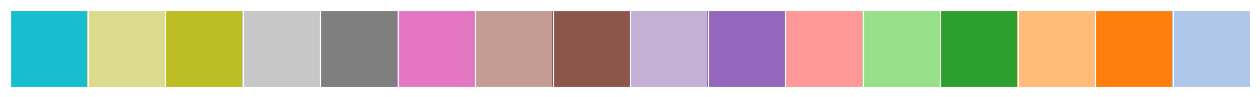

In [44]:
colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)
sns.set_style("darkgrid")

In [45]:
cwd = os.getcwd()
data_path = os.path.join(cwd, "data/AirPassengers.csv")

In [46]:
def study_stationarity(dff, rolling_1, rolling_2):
    
    passengers = dff["Passengers"]
    passengersRolling = dff['Passengers'].rolling(window=rolling_1).mean()
    passengersRolling2 = dff['Passengers'].rolling(window=rolling_2).mean()
    
    x = np.arange(len(passengersRolling2.dropna()))
    y = passengersRolling2.dropna()
    coefficients = np.polyfit(x, y, 1)
    a = coefficients[0]  # Slope
    b = coefficients[1]  # Intercept
    regression_curve = a * x + b
    
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print('Coefficient b:', b)
    print('Coefficient a:', a)
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print("EXPECTING --> a = 0 <-- for stationarity")
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,9))
    fig.suptitle("Passengers Evolution Tendency", fontsize=20)

    # Plotting the normal distribution curve
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengers,
        color = colors[1],
        label="Passengers Evolution"
    )
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengersRolling,
        color = colors[6],
        label=f"Rolling {rolling_1}",
        linewidth=2
    )
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengersRolling2,
        color = colors[4],
        label=f"Rolling {rolling_2}",
        linewidth=2
    )
    
    # Displaying the plot
    plt.show()
    
    
    passengersVar = dff["Passengers"].var()
    passengersRollingVar = dff['Passengers'].rolling(window=rolling_1).var()
    passengersRollingVar2 = dff['Passengers'].rolling(window=rolling_2).var()
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,9))
    fig.suptitle("Variance Evolution Tendency", fontsize=20)
    
    
    # Plotting the normal distribution curve
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengersVar,
        color = colors[1],
        label="Variance Evolution"
    )
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengersRollingVar,
        color = colors[6],
        label=f"Rolling Variance {rolling_1}",
        linewidth=2
    )
    sns.lineplot(
        ax=ax,
        x = dff.index,
        y = passengersRollingVar2,
        color = colors[4],
        label=f"Rolling Variance {rolling_2}",
        linewidth=2
    )
    
    # Displaying the plot
    plt.show()
    

In [47]:
def asses_heteroskedacticity(data):
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print("Heteroskedacticity -> ")
    test_results = Heteroskedasticity.run_all_tests(data)
    print(test_results)
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")  
    
    
def assess_stationarity(data, significance_level=0.05):
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")  
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < significance_level:
        print("Data is stationary")
    else:
        print("Data is not stationary")
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")  

def assess_stationarity_with_kpss(data, significance_level=0.05):
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")  
    statistic, p_value, n_lags, critical_values = kpss(data, regression='c')
    # regression='c' indicates constant is used in the test equation.
    # For testing around a trend, use 'ct'
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critical values:')
    for key, value in critical_values.items():
        print(f'\t{key} : {value}')
    if p_value < significance_level:
        print("Data is not stationary")
    else:
        print("Data is stationary")
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")  

# Data import

## Import

In [48]:
df = pd.read_csv(data_path)

## Reworking

In [49]:
# Convert the "Month" column to datetime format
df["Month"] = pd.to_datetime(df["Month"])
# Set the "Month" column as the index
df.set_index("Month", inplace=True)
df = df.rename(columns={'#Passengers': 'Passengers'})

# Exploration

In [50]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [52]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## VISUAL Exploration

### Données Passagers

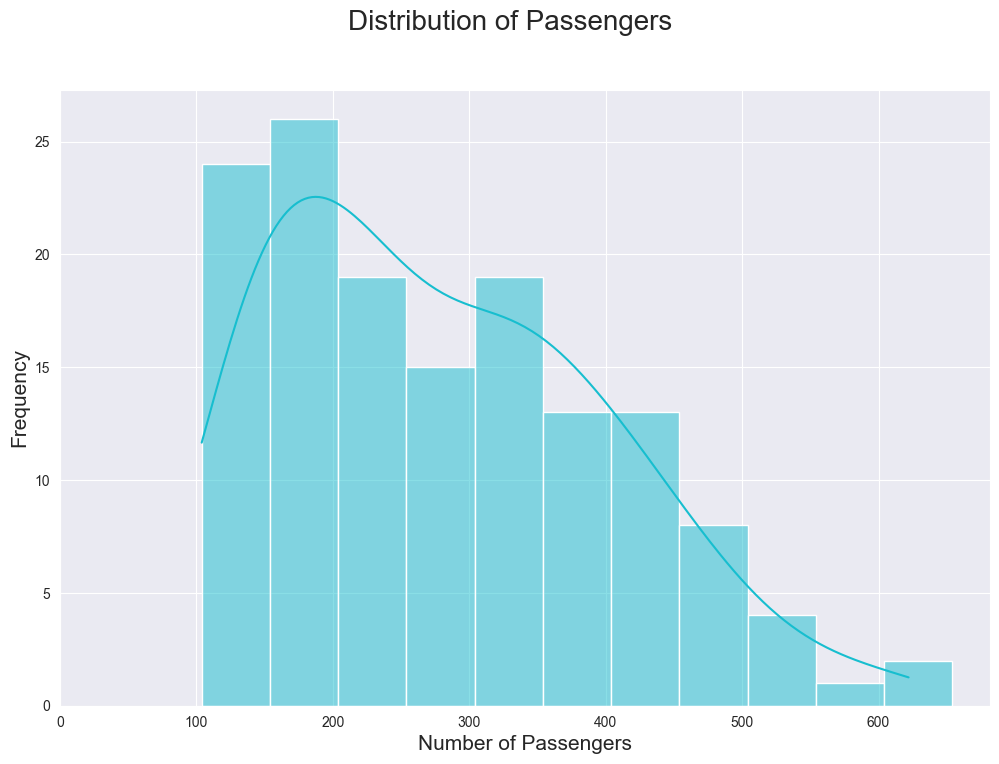

In [53]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
fig.suptitle("Distribution of Passengers", fontsize=20)

sns.histplot(
    ax=ax,
    data=df["Passengers"],
    kde=True,
    color=colors[0],
    binwidth=50
)

ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Number of Passengers", fontsize=15)

plt.xlim(0)

# Displaying the plot
plt.show()

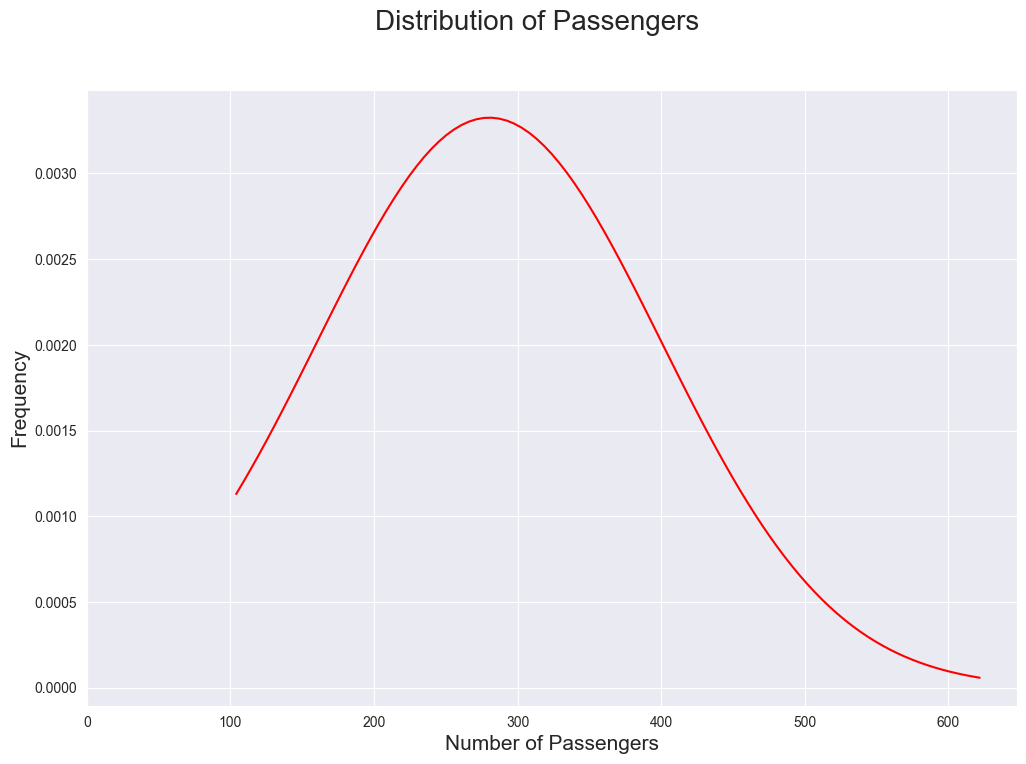

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
fig.suptitle("Distribution of Passengers", fontsize=20)

# Plotting the normal distribution curve
mean = df['Passengers'].mean()
std = df['Passengers'].std()
x = np.linspace(df['Passengers'].min(), df['Passengers'].max(), 100)
y = norm.pdf(x, mean, std)
ax.plot(x, y, color='r', label='Normal Distribution')
ax.set_ylabel('Density')

ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Number of Passengers", fontsize=15)

plt.xlim(0)

# Displaying the plot
plt.show()

### Moving Average Passengers and Variance Analaysis

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Coefficient b: 102.18781094527367
Coefficient a: 2.66650768712827
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
EXPECTING --> a = 0 <-- for stationarity


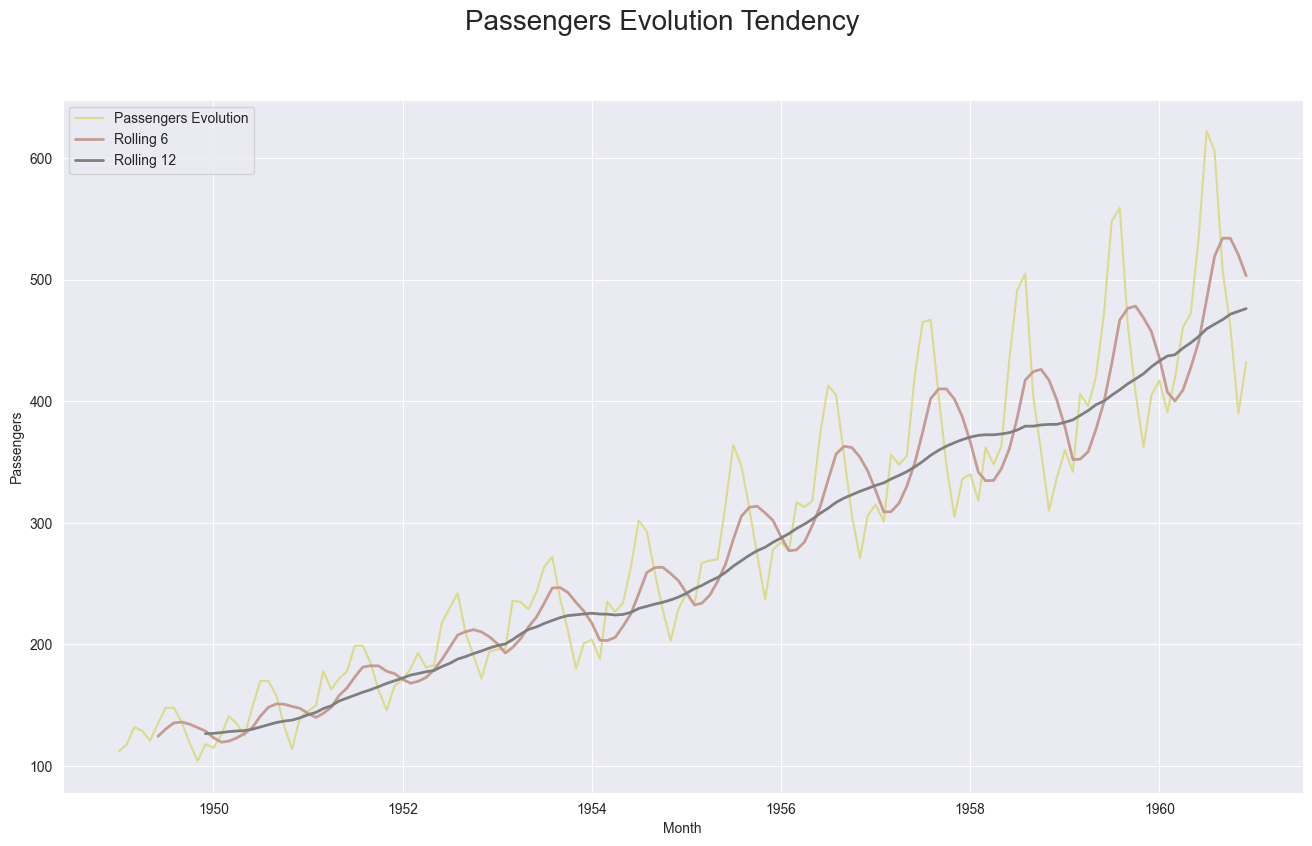

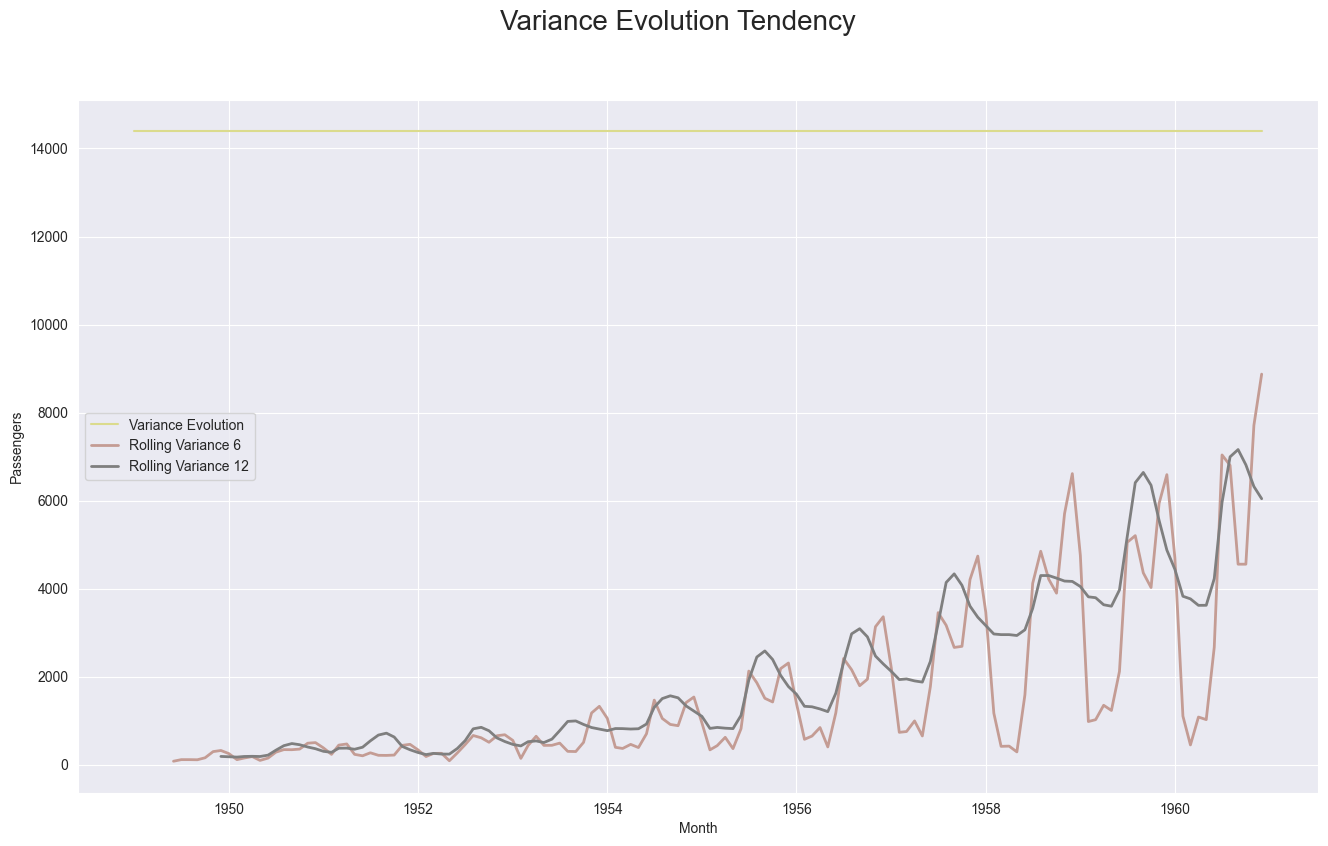

In [55]:
study_stationarity(df, 6, 12)

-------

In [56]:
assess_stationarity(df["Passengers"], significance_level=0.05)
assess_stationarity_with_kpss(df["Passengers"], significance_level=0.05)

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Data is not stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
KPSS Statistic: 1.6513122354165206
p-value: 0.01
num lags: 8
Critical values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Data is not stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_50087/3363211624.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(data, regression='c')


------

**Conclusions:**

=> Augmentation assez claire => Trend

=> Passengers = 2.6 . year + 100

- Is this time serie stationary or not?

=> The series doesn't seem stationary when we see the variance evolution and the pattern in the passengers evolution
- What is its tendancy?

=> Passengers Number tends to rise over time by a coefficient of 2.6 per Year
- What about heteroskedasticity?

In [57]:
asses_heteroskedacticity(df["Passengers"])

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Heteroskedacticity -> 
{'White': 4.345754466128766e-07, 'Breusch-Pagan': 4.559001856883369e-07, 'Goldfeld-Quandt': 8.812950329262266e-13}
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


**Conclusions:**

- What about heteroskedasticity?

=> All the p-value are lower than 0.05. It seems that the Residual are NOT distributed with equal variance

=> Following the graphical analysis, there is actually a pattern that make the White / BP / GQ tests negative

### Zoom on one year

In [58]:
start_date = df.index.min() + pd.DateOffset(years=10)
end_date = start_date + pd.DateOffset(years=1)
filtered_df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
passengers = filtered_df["Passengers"]

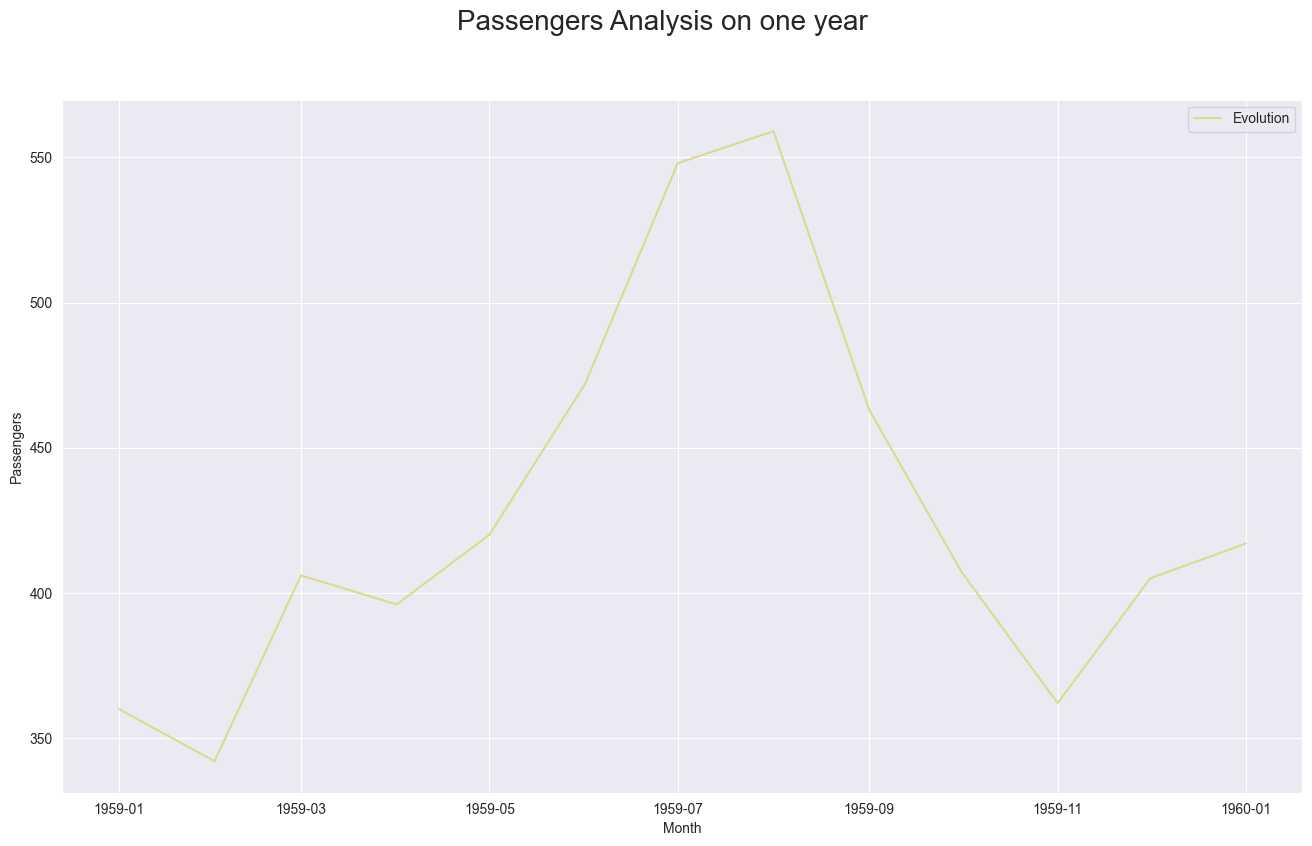

In [59]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,9))
fig.suptitle("Passengers Analysis on one year", fontsize=20)




# Plotting the normal distribution curve
sns.lineplot(
    ax=ax,
    x = filtered_df.index,
    y = passengers,
    color = colors[1],
    label="Evolution"
)

# Displaying the plot
plt.show()

## Working on Stationarity -> diff °1

In [60]:
df_diff = pd.DataFrame(df["Passengers"].diff().dropna())
df_diff = df_diff

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Coefficient b: 2.4468085106383004
Coefficient a: -0.003850050658561333
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
EXPECTING --> a = 0 <-- for stationarity


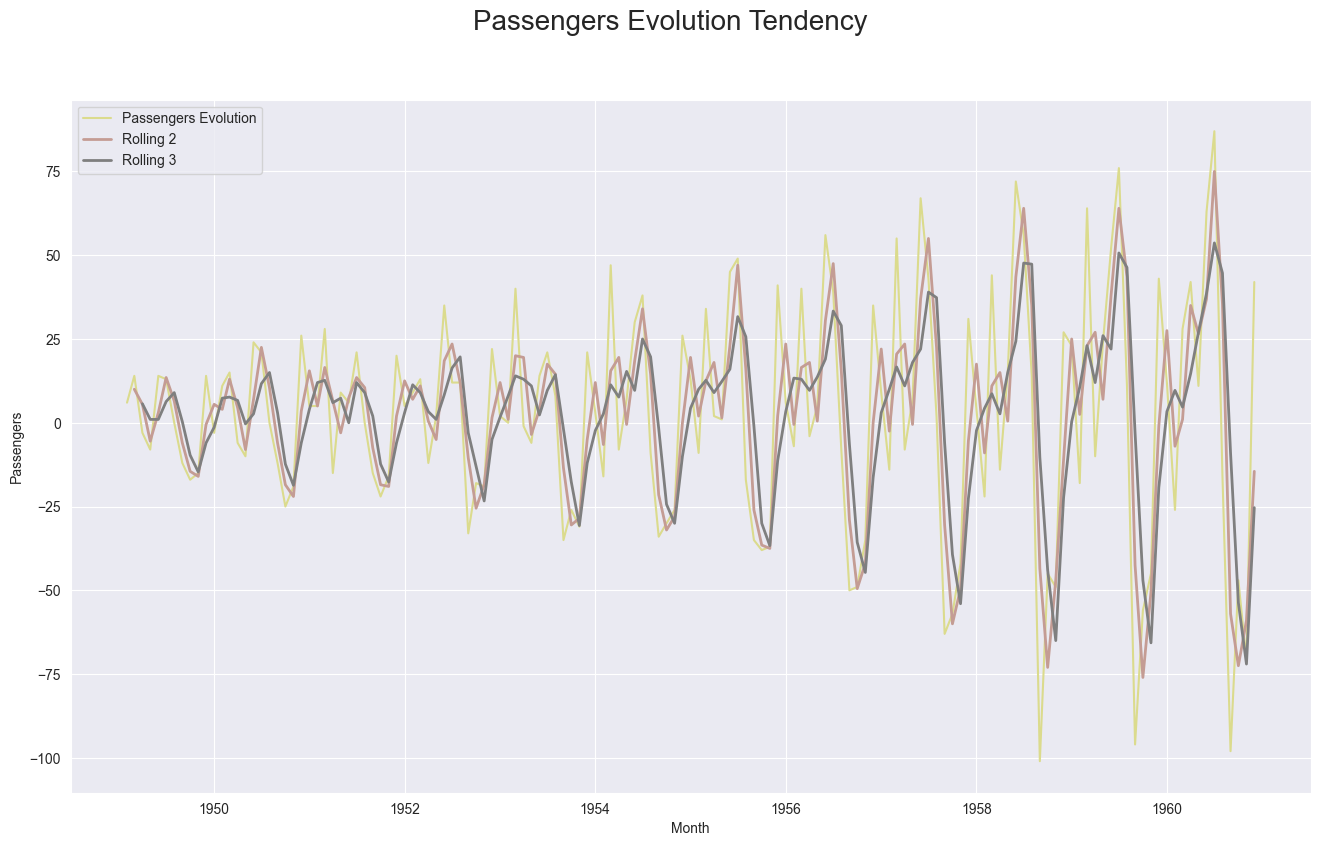

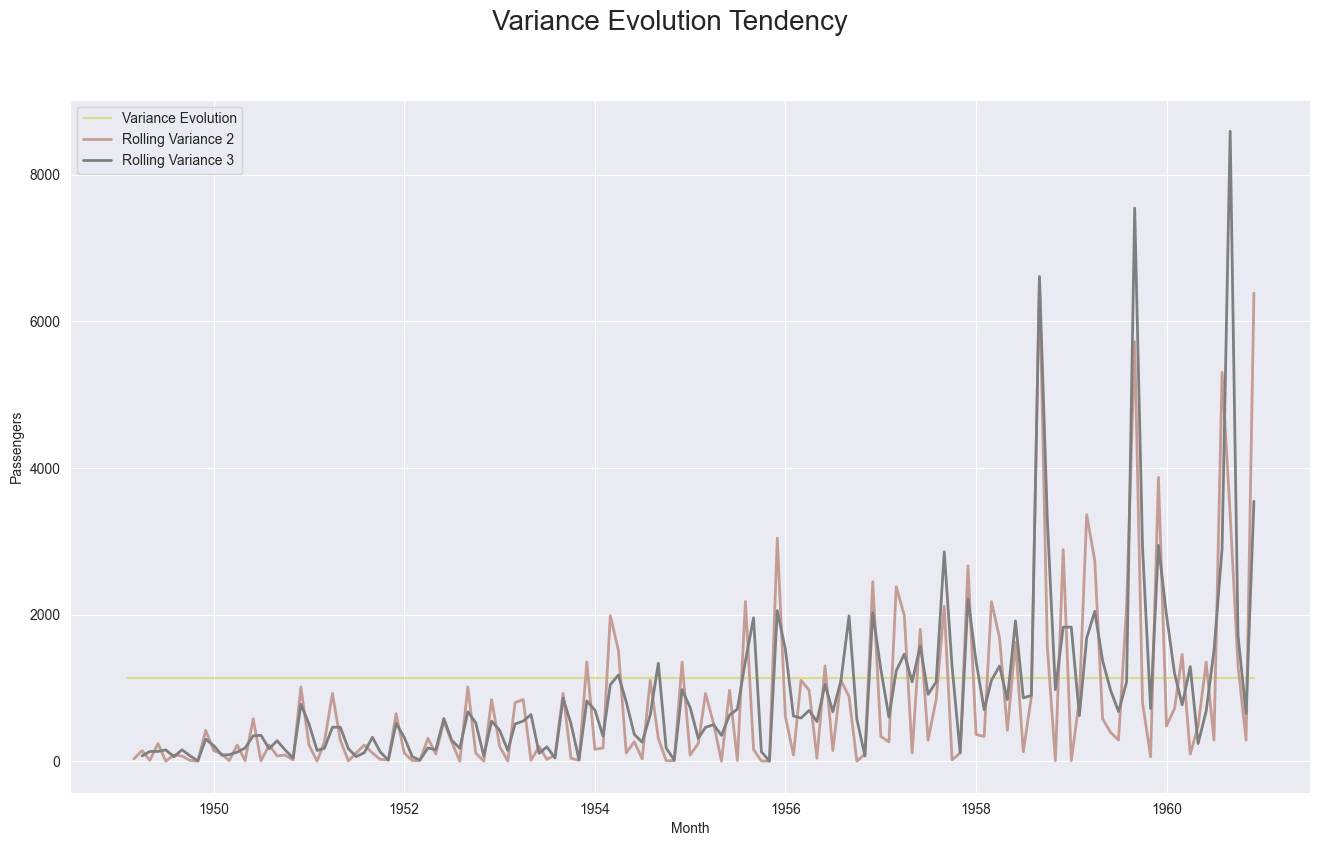

In [61]:
study_stationarity(df_diff, 2, 3)

**Observations:**
 - What about the stationarity?
 - What about the variance and how to deal with it?

In [62]:
assess_stationarity(df_diff["Passengers"], significance_level=0.05)
assess_stationarity_with_kpss(df_diff["Passengers"], significance_level=0.05)

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Data is not stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
KPSS Statistic: 0.023897614400183967
p-value: 0.1
num lags: 7
Critical values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Data is stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_50087/3363211624.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(data, regression='c')


**Conclusion:**
 - What about mean and deviation? Stationarity?
 
 => The DAF Test seems to tell that data are still not stationary but the KPSS yes.
 
 => Why the both are not stationary we should continue to transform our data

**Observations:**
 - What about mean and deviation? Stationarity?
 
 => For the mean of data, the rolling values seems to be centered around zero. 
 
 => The amplitude of the oscillation increases overr time, but the statistical value of mean no
 
<span style="color:green">Then, it should be possible to apply ARIMA on these transformed data, with order 1 integration: ARIMA(p,1,q)</span>

## Main Transformation

In [63]:
data = df

In [64]:
data = np.log(data["Passengers"]).dropna()
data = pd.DataFrame(data.diff().dropna())
#data = pd.DataFrame(data.diff().dropna())
data

,Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Coefficient b: 0.012258024298380136
Coefficient a: -3.47007451559971e-05
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
EXPECTING --> a = 0 <-- for stationarity


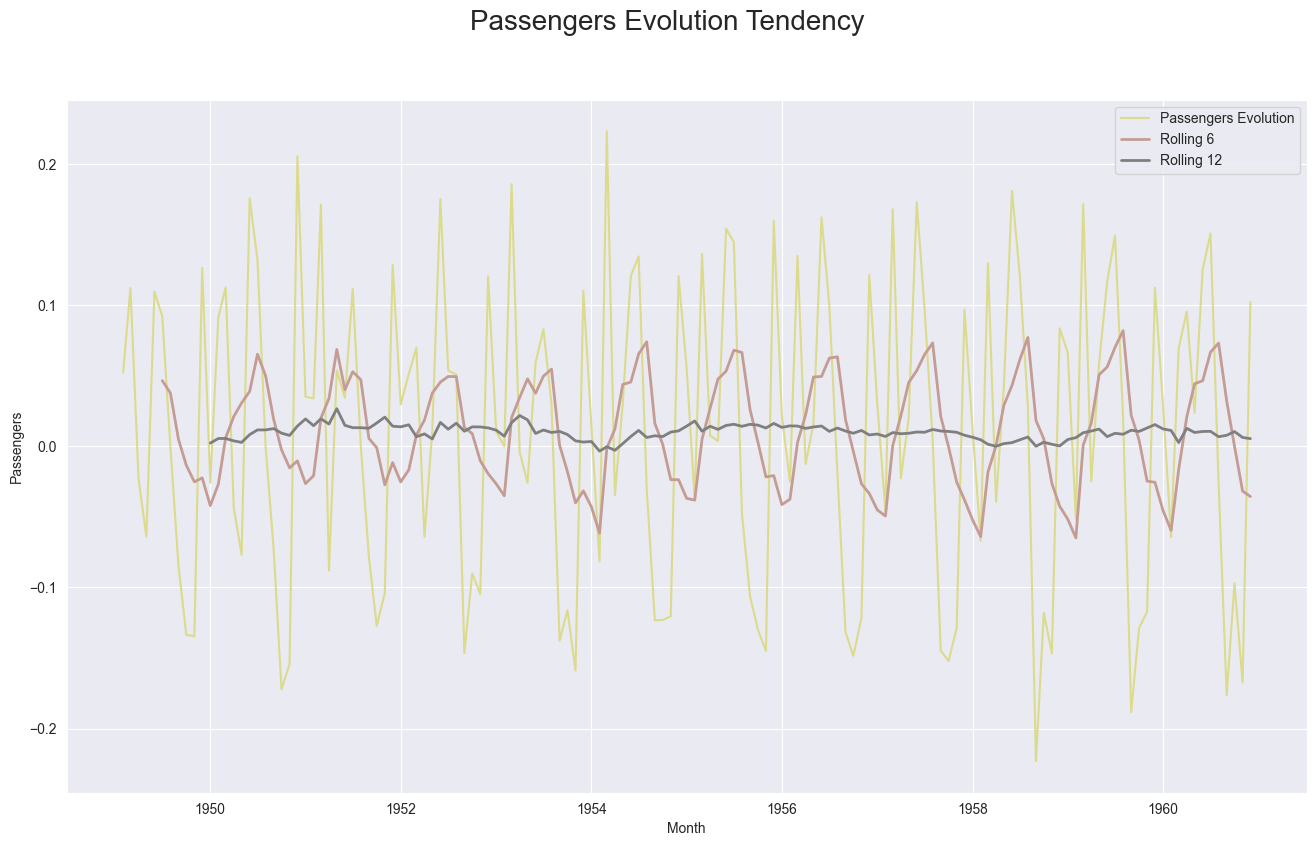

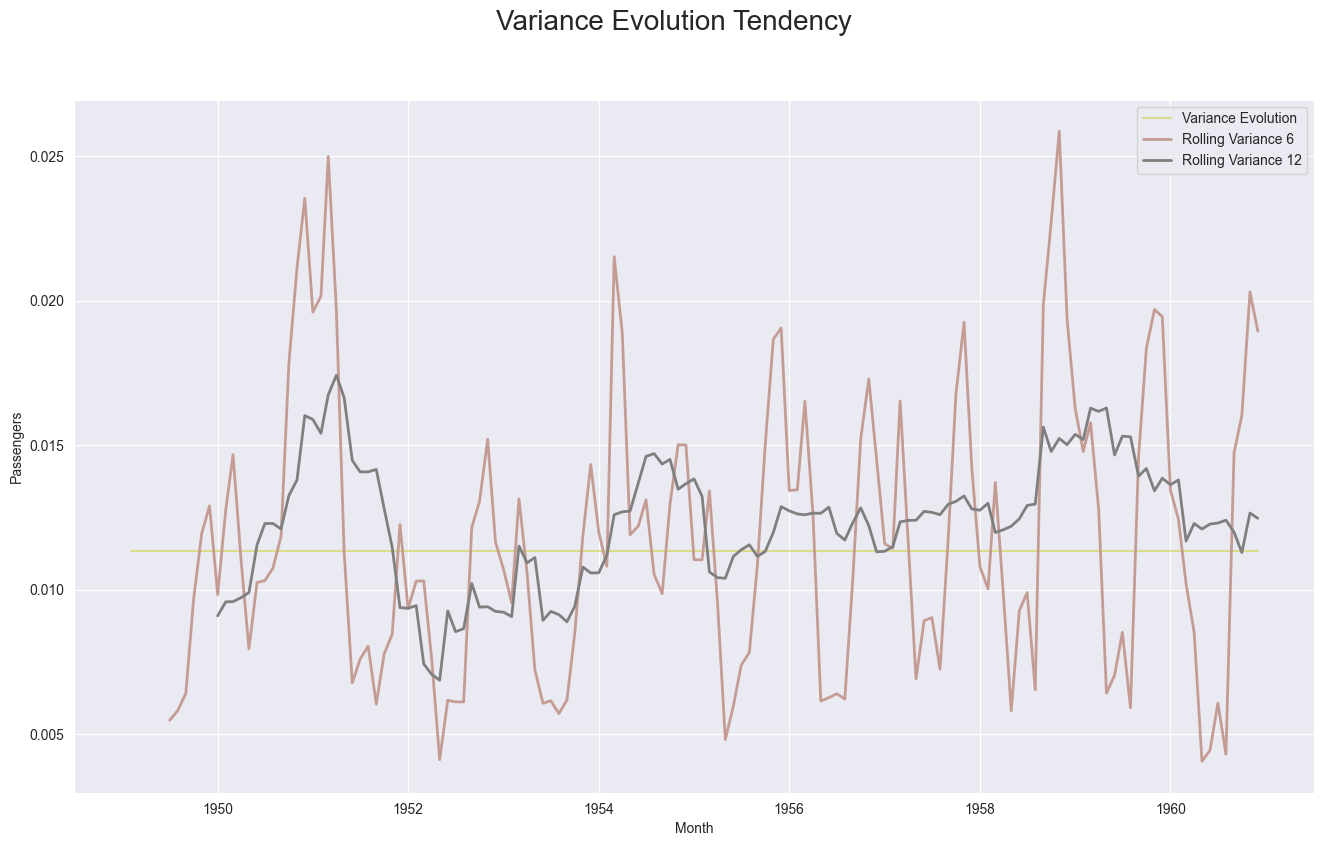

In [65]:
study_stationarity(data, 6, 12)

------

In [66]:
assess_stationarity(data, significance_level=0.05)
assess_stationarity_with_kpss(data, significance_level=0.05)

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579
Data is not stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
KPSS Statistic: 0.038304469546740647
p-value: 0.1
num lags: 6
Critical values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Data is stationary
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_50087/3363211624.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(data, regression='c')


-----

**Conclusions:**

=> After one log transform, plus one diff, and one other diff we finally have stationary data

### PACF

In [67]:
df['Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

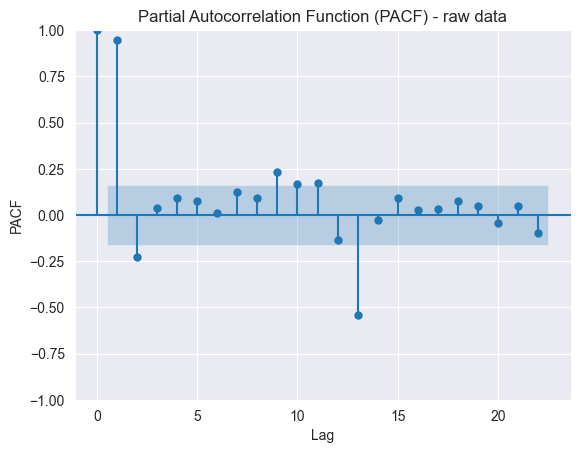

In [68]:
plot_pacf(df['Passengers'])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF) - raw data')
plt.show()

### ACF

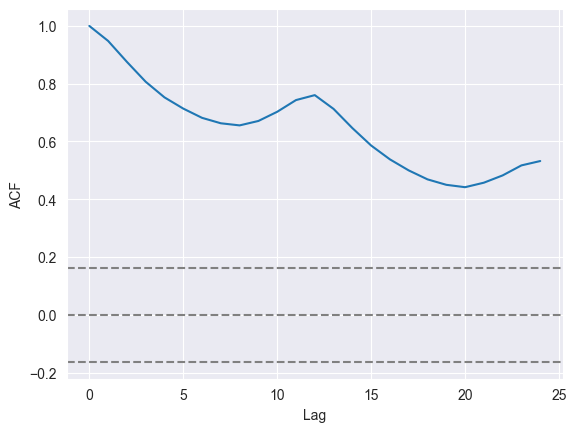

In [69]:
# Calculate the ACF
acf = stattools.acf(df['Passengers'], nlags=24)
# Plot the ACF
plt.plot(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df['Passengers'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['Passengers'])), linestyle='--', color='gray')
plt.show()

----

##### Train/Test split challenges

In [70]:
airline = df["Passengers"]

In [71]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [72]:
airline

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

In [86]:
# Hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline, '1959-01-01')

In [87]:
train

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
Name: Passengers, Length: 120, dtype: int64

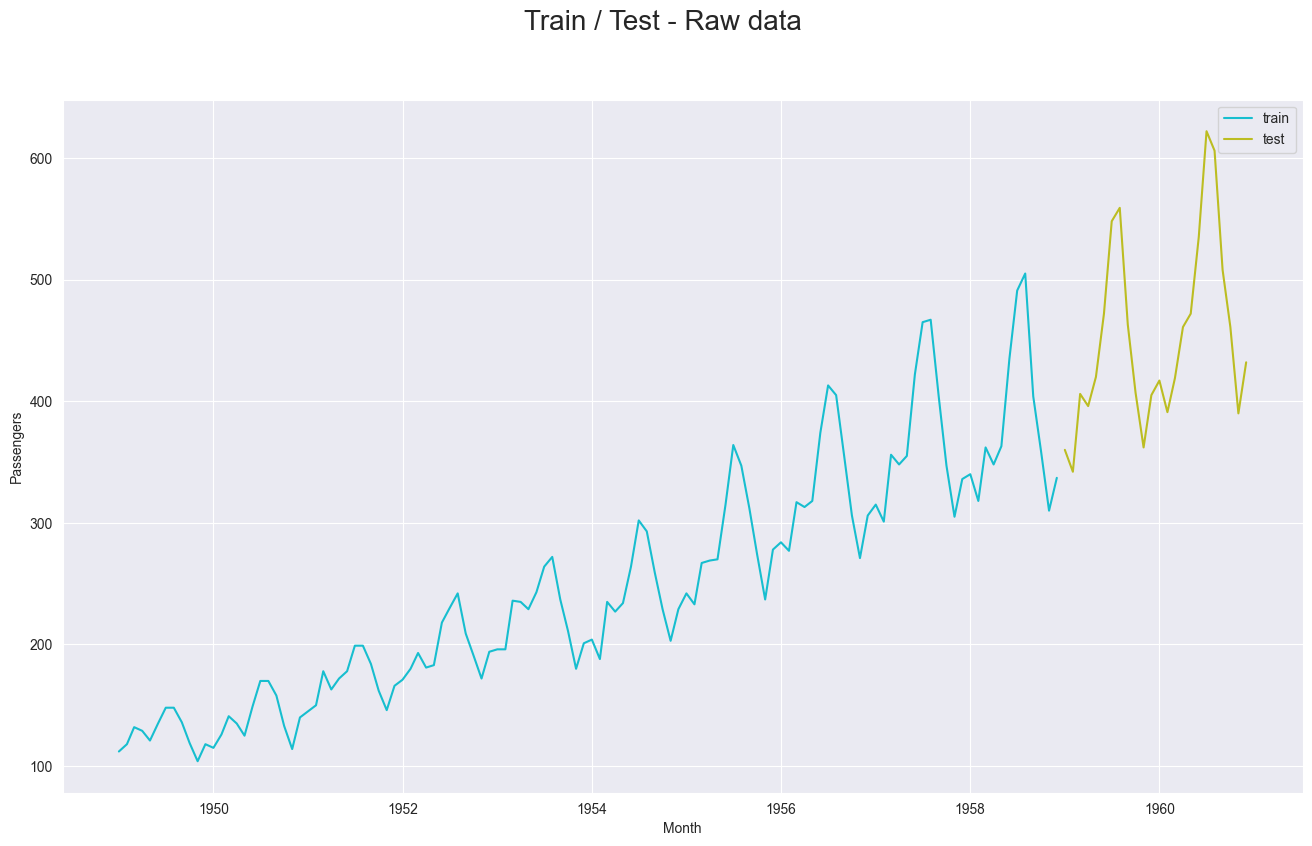

In [88]:
# Plot train and test sets
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,9))
fig.suptitle("Train / Test - Raw data", fontsize=20)

sns.lineplot(
    ax=ax,
    data = train,
    label="train",
    color=colors[0]
)
sns.lineplot(
    ax=ax,
    data = test,
    label="test",
    color=colors[2]
)
plt.legend()

In [89]:
# Do not forget to change your data (log)
train_adj_log = np.log(train)

<Axes: xlabel='Month', ylabel='Passengers'>

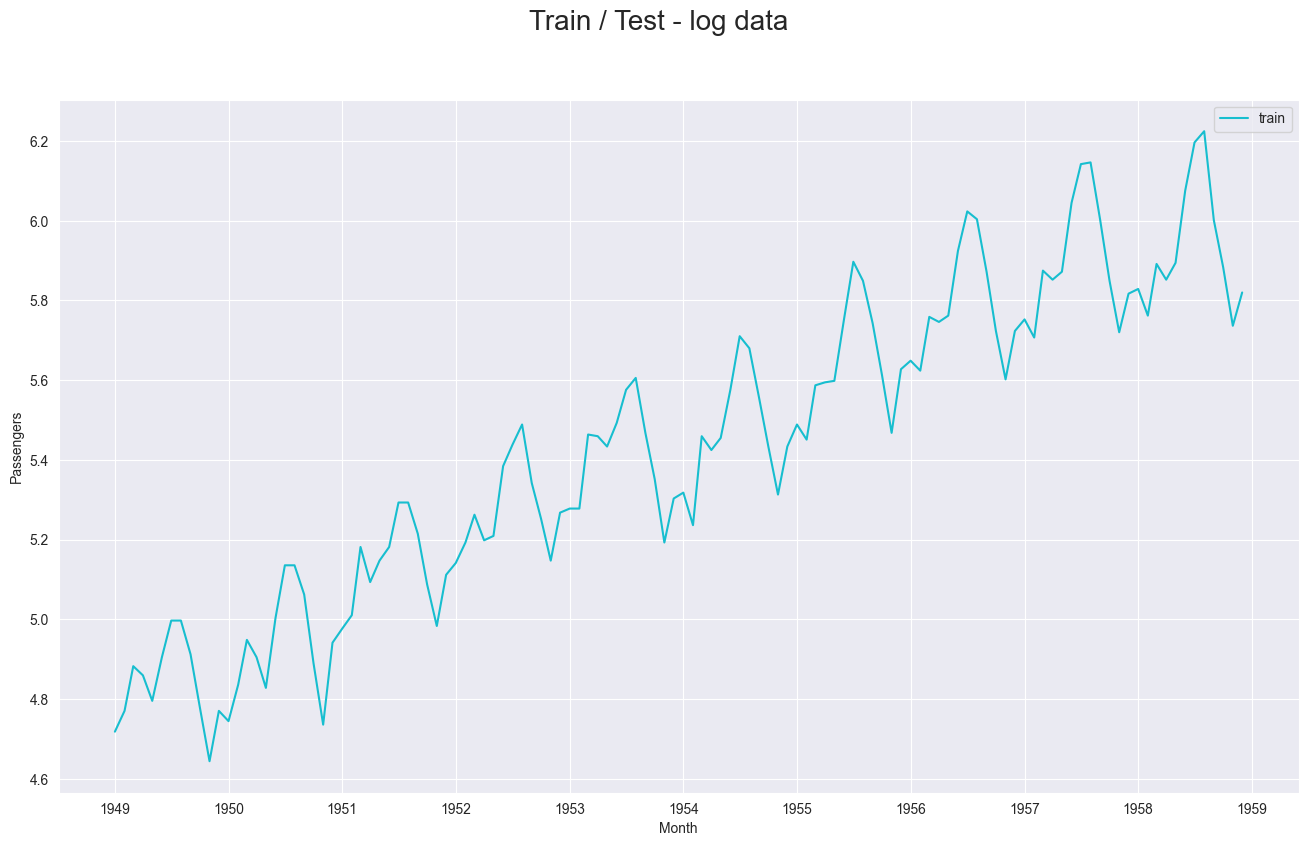

In [90]:
# Plot train and test sets
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,9))
fig.suptitle("Train / Test - log data", fontsize=20)

sns.lineplot(
    ax=ax,
    data = train_adj_log,
    label="train",
    color=colors[0]
)

Afin de valider les paramètres $p$ (*AR*) et $q$ (*MA*) du modèle ARIMA, l'on peut calculer l'auto-corrélation des données temporelles.
- Pour déterminer $p$ nous utiliserons l'autocorrelation des données par une donnée passée avec un décalage temporel (appelé *lag* en anglais). On utilisera pour cela la PACF (*Partial Auto Correlation Function*). La fonction PACF cherche à déterminer la correlation entre les données $Y_t$ et $Y_{t-i}$. La valeur de $p$ est déterminée par $PACF_i \approx 0$  
- pour déterminer $q$, on utilisera l'ACF (*Auto Correlation Function*). La fonction ACF calcule la correlation entre la série temporelle et elle-même avec un décalage temporel. Soit calculer la correlation de $Y_(t, t-1, ...)$ avec $Y_(t-i, t-i-1, ...)$.

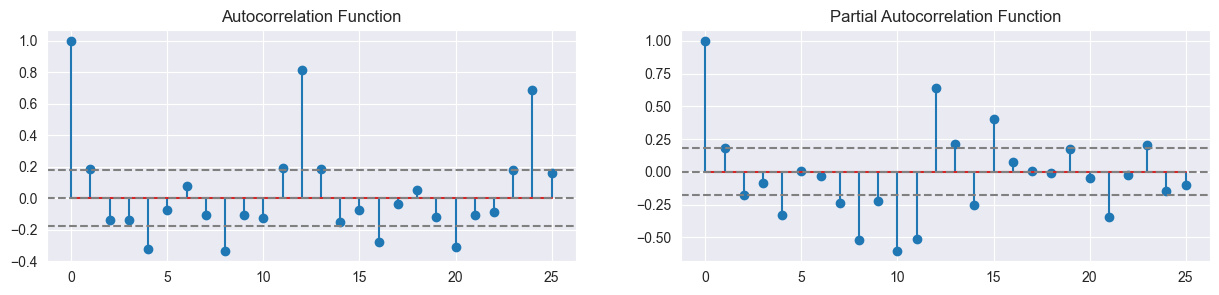

In [91]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

n_sample = len(train)
lag_acf = acf(np.log(train).diff().dropna(), nlags=25)
lag_pacf = pacf(np.log(train).diff().dropna(), nlags=25)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') # represent 95 % of a gaussian data
plt.axhline(y=pct_95, linestyle='--', color='gray') # represente 95 % of a gaussian data
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title('Partial Autocorrelation Function')
# plt.legend()
plt.show()

**Observations**
- What can you tell about the correlation for ACF and PACF?

=> ACF seems to show pics arround 12 or 24. Le schéma semble se répéter tous les 12 mois

=> PACF semble plus autour de 7 ou 12. Au delà de 12, la corrélation devient vraiment très faible.

=> Les deux graphes ont des cuts off lags ce qui suggère un modèle ARIMA(p,q)

=> Les graphes ACF et PACF deviennent insuffisant pour trouver les valeurs de p et q

=> On passe par le AIC et le BIC

- Can you explain what you observe on this data (e.g. reasons for observed changes)?

=> L'ACF détermine la corrélation de la série avec elle même selon un lag fixé. Indication sur les coeff AutoRegression 

=> On a vu sur les courbes qu'un pattern se répète tous les ans. 

=> C'est pour ca qu'on retrouve des pics aux multiples de 12 mois. 

=> La PACF donne des indications sur la calibration du Moving Average

=> Le PACF lui corrèle la valeur de la série la valeur à un lag spécifique sans prendre en compte les lags intermédiaires

## AIC / BIC

In [92]:
def find_lowest_AIC_BIC(max_p, max_q):
    best_tuple = (0,0)
    previous_aic = 1000
    previous_bic = 1000

    for p in range(max_p):
        for q in range(max_q):
            
            data = np.log(train)
            d=1
            model = sm.tsa.ARIMA(data, order=(p, d, q))  # Replace p, d, and q with the appropriate values
    
            # Estimate the parameters of the model
            model_fit = model.fit()#suppress_warnings=True)
    
            # Get the AIC and BIC values
            aic = model_fit.aic
            bic = model_fit.bic
            
            if abs(aic) < previous_aic: #and abs(bic) < previous_bic:
                best_tuple = (p,q)
                
            previous_aic = abs(aic)
            previous_bic = abs(bic)
            
    return best_tuple

In [93]:
#best_tuple = find_lowest_AIC_BIC(13, 13)

In [94]:
#print(best_tuple)

# MODEL (1, 1, 1)

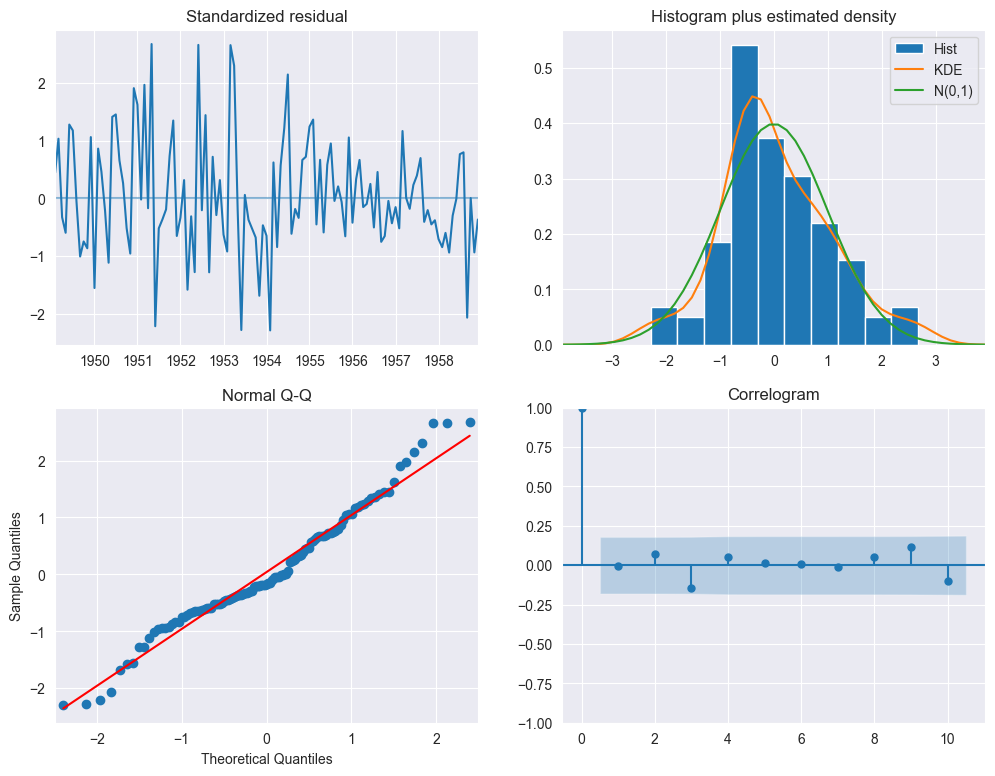

In [95]:
from pmdarima.arima import ARIMA
#(p, d, q)
model = ARIMA(order=(12, 1, 2), suppress_warnings = True) # seasonal_order=(0, 1, 1, 12)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9));

------

- **Standardized residuals plot**

No Pattern in the residual

==> OK

- **Histogram plus estimated density plot**

Green and Orange very sligthly different. We can consider the model good.

==> OK

- **Normal Q-Q plot**

The tails of the points is not really aligned with the normal distribution. We can probably improve our model.

==> NOT OK

- **Correlogram plot**

If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.
Lag 6 is pretty correlated... again, the model can be improved. 

==> NOT OK

In [96]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:              SARIMAX(12, 1, 2)   Log Likelihood                 203.149
Date:                Fri, 23 Jun 2023   AIC                           -374.298
Time:                        12:34:03   BIC                           -329.832
Sample:                    01-01-1949   HQIC                          -356.242
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0051      0.006      0.794      0.427      -0.008       0.018
ar.L1          0.0276      0.105      0.264      0.792      -0.178       0.233
ar.L2         -0.0607      0.095     -0.637      0.524      -0.247       0.126
ar.L3         -0.0208      0.072     -0.289      0.773      -0.162       0.120
ar.L4         -0.1050      0.085     -1.236      0.217      -0.271       0.062
ar.L5          0.0108      0.075      0.144      0.885      -0.136       0.158
ar.L6         -0.0426      0.078     -0.545      0.586      -0.196       0.111
ar.L7         -0.0614      0.081     -0.757      0.449      -0.220       0.098
ar.L8         -0.1055      0.071     -1.490      0.136      -0.244       0.033
ar.L9         -0.0208      0.091     -0.227      0.820      -0.200       0.158
ar.L10        -0.0457      0.074     -0.621      0.534      -0.190       0.098
ar.L11        -0.0048      0.076     -0.063      0.950      -0.154       0.144
ar.L12         0.8064      0.074     10.851      0.000       0.661       0.952
ma.L1         -0.3921      0.152     -2.583      0.010      -0.690      -0.095
ma.L2         -0.0474      0.133     -0.356      0.722      -0.308       0.213
sigma2         0.0017      0.000      6.484      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.19
Prob(Q):                              0.97   Prob(JB):                         0.20
Heteroskedasticity (H):               0.33   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

----

The values of Prob(Q) and Prob(JB) are both more than 0.05, so we cannot reject the null hypothesis that the residuals are Gaussian normally distributed.

-----

In [104]:
train.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01'],
              dtype='datetime64[ns]', name='Month', length=120, freq=None)

In [105]:
y_pred.index

DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [103]:
test.index

DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

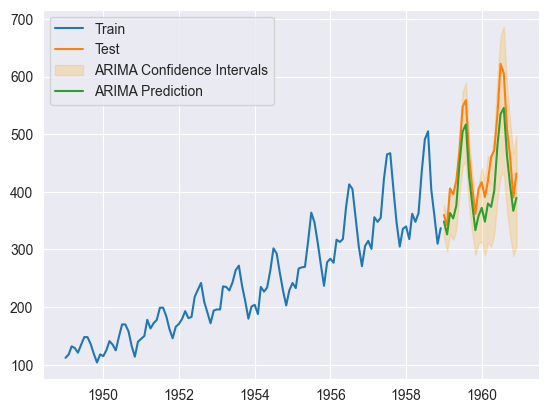

In [101]:
# Use np.exp(prediction) to change log data back to "Normal"
plt.plot(train, label='Train')
plt.plot(test, label='Test')
y_pred, conf_int = model.predict(n_periods=len(test), return_conf_int=True)


plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')
plt.legend()
plt.show()

Now, find the error!

In [43]:
def find_model_rmse(test_data, y_pred_transformed):
    #Calculate RMSE and RMSE/mean(test)
    RMSE = np.sqrt(mean_squared_error(test_data, y_pred_transformed))
    RMSE_MEAN = RMSE/np.mean(test)
    print(f"RMSE --> {RMSE}")
    print(f"RMSE/MEAN --> {RMSE/np.mean(test)}")
    return RMSE, RMSE_MEAN

In [44]:
find_model_rmse(test, np.exp(y_pred))

RMSE --> 1.3812354257840997
RMSE/MEAN --> 0.09310708156400894


(1.3812354257840997, 0.09310708156400894)

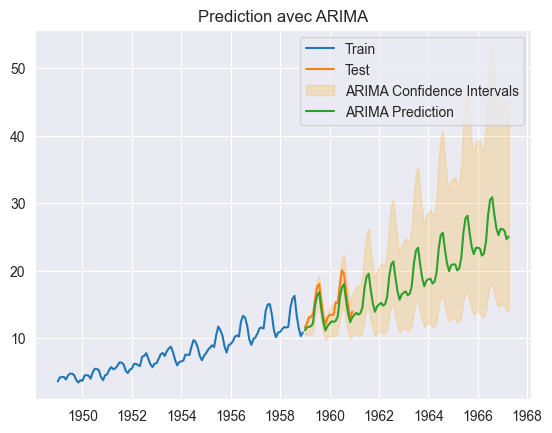

In [45]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=100, return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

**Conclusions**
- With only 1-1-1 arima model we miss the seasonal variation and we catch onyl the trend
- For sur, confidence is wrong as we catch only the trend forgetting every fluctuation

# CV with ARIMA

In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    res = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("MAPE", res)
    return res

In [47]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [48]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [49]:
cv = RollingForecastCV(h=50, step=5) # initially uses 1/3 of the training size

In [50]:
airline_adj = airline / airline.index.days_in_month
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test)

cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)
np.mean(cv_results)

MAPE 2.974412475154948
MAPE 3.6851805416311056
MAPE 4.30083428996112
MAPE 3.6144072241487515
MAPE 1.666328788498219
MAPE 1.6095117528252056
MAPE 2.1109208889337294
MAPE 2.4927768963007355


2.8067966071817265

In [51]:
#how many splits did we get?
len(cv_results)

8

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?
* In each case what size is the data is the model training on?

**CONCLUSION**

**definition**
The RollingForecastCV is a cross-validation strategy specifically designed for time series data. It allows you to perform rolling or expanding window cross-validation, where the model is trained and evaluated on different subsets of the data over time.

- h: It represents the forecast horizon or the number of steps ahead you want to predict. In your example, h=1 means you are interested in predicting the value for the next single step or observation in the future.

- step: It determines the number of steps or observations the rolling window moves forward after each iteration. In your example, step=10 means that after each iteration, the rolling window will move forward by 10 observations.

**Method**

1 - Initially, the training data is divided into three equal parts. The first two-thirds of the training data are used as the initial training set.

2 - The model is trained on the initial training set.

3 - After training, the model makes a forecast for the next h steps.

4 - The first h true values of the forecasted series are then compared with the corresponding true values from the test set (i.e., the next h steps after the initial training set).

5 - The performance metric (e.g., MAPE) is calculated based on the comparison of forecasted values with the true values.

6 - The rolling window moves forward by step steps. The model is retrained on the updated training set, and the process repeats from step 3.

7 - This process continues until the rolling window reaches the end of the training data. Each iteration provides a performance metric (e.g., MAPE) for the forecasted values at each step.

By using the rolling window cross-validation approach, you can assess the performance of your model over time and evaluate its ability to make accurate forecasts as new observations become available.

------

# Dealing now with seasonality: SARIMA

As previously seen, ARIMA model is for stationary data. It may even works for data presenting seasonality. However, seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

*eg:Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of p=12*12 to comprehend seasonality of the problem.*

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

In [52]:
# Make sure data form

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_std(a, n=3) :
    j = len(a) - n
    mov_std = np.array([np.std(a[k:k+n]) for k in range(j)])
    return mov_std

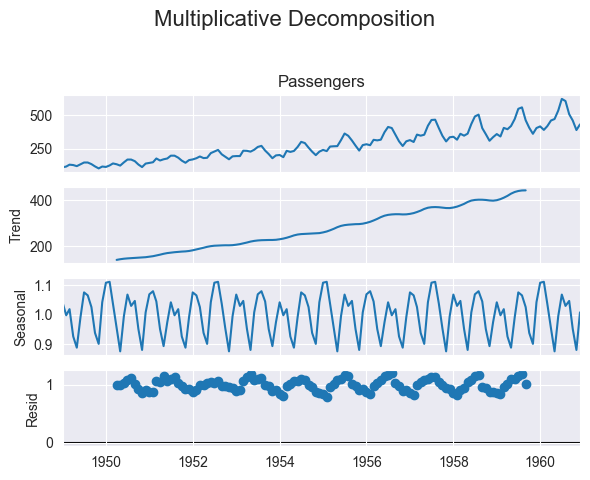

In [53]:
# Plot data, trend, seasonal and random infos one by one using arima.decompose
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (6,5)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

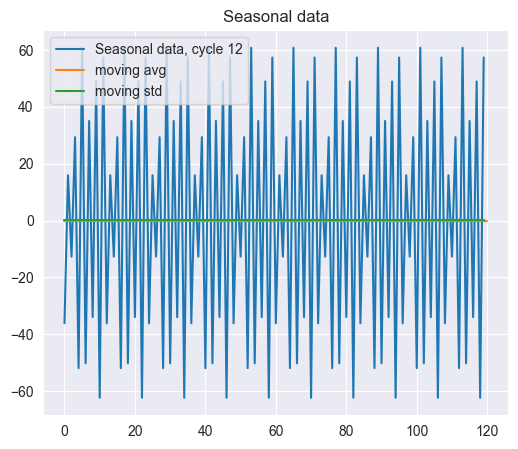

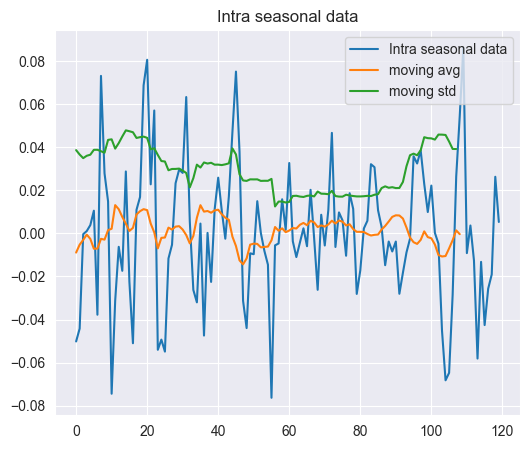

In [54]:
from pmdarima import arima
decomposed = arima.decompose(np.log(train).values, 'additive', m=12)

seasonal_data = decomposed.seasonal
seasonal_data = seasonal_data[~np.isnan(seasonal_data)]

plt.plot(np.diff(seasonal_data, 12), label='Seasonal data, cycle 12')
plt.plot(moving_average(seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(seasonal_data, n=12), label='moving std')
plt.title('Seasonal data')
plt.legend()
plt.show()

non_seasonal_data = decomposed.random[~np.isnan(decomposed.random)]
plt.plot(non_seasonal_data, label='Intra seasonal data')
plt.plot(moving_average(non_seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(non_seasonal_data, n=12), label='moving std')
plt.title('Intra seasonal data')
plt.legend()
plt.show()

**Observations**
- What can you conclude about stationarity of seasonal data? Can you then define D and freq?
- Does intra-seasonal data show specific seasonality? What is d (2, 1 or 0)?

# Quote statistical tests to define stationarity

**Augmented Dickey-Fuller (ADF)** 

- The ADF test is widely used to test for stationarity in a time series. It tests the null hypothesis that a unit root is present in the series. If the p-value of the test is less than a chosen significance level (e.g., 0.05), we reject the null hypothesis and conclude that the series is stationary. The statsmodels library in Python provides the adfuller() function to perform the ADF test.

**Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**

- The KPSS test is another commonly used test for stationarity. It tests the null hypothesis that the series is trend-stationary (or stationary around a deterministic trend) against the alternative hypothesis of a unit root. If the p-value is greater than the significance level, we fail to reject the null hypothesis, indicating stationarity. The statsmodels library also provides the kpss() function to perform the KPSS test.

In [55]:
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs

In [56]:
freq = 12
ocsb_diffs = nsdiffs(
    train,
    test='ocsb',
    m=12, # time serie frequency
    max_D=12 # max D for seasonality
)
ch_diffs = nsdiffs(train, test='ch', m=freq, max_D=12)
n_diffs = max(ch_diffs, ocsb_diffs)
print(f'Here seasonality for supposed frequency of {freq} is {n_diffs=}')

Here seasonality for supposed frequency of 12 is n_diffs=1


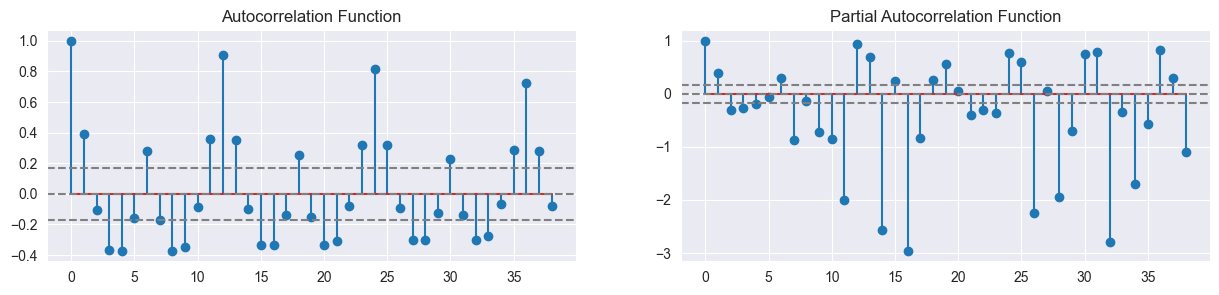

In [57]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

x = np.diff(seasonal_data)

n_sample = len(x)
lag_acf = acf(x, nlags=38)
lag_pacf = pacf(x, nlags=38)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') 
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

##### Define q and p
Both ACF and PACF avec the lag 1 out of range

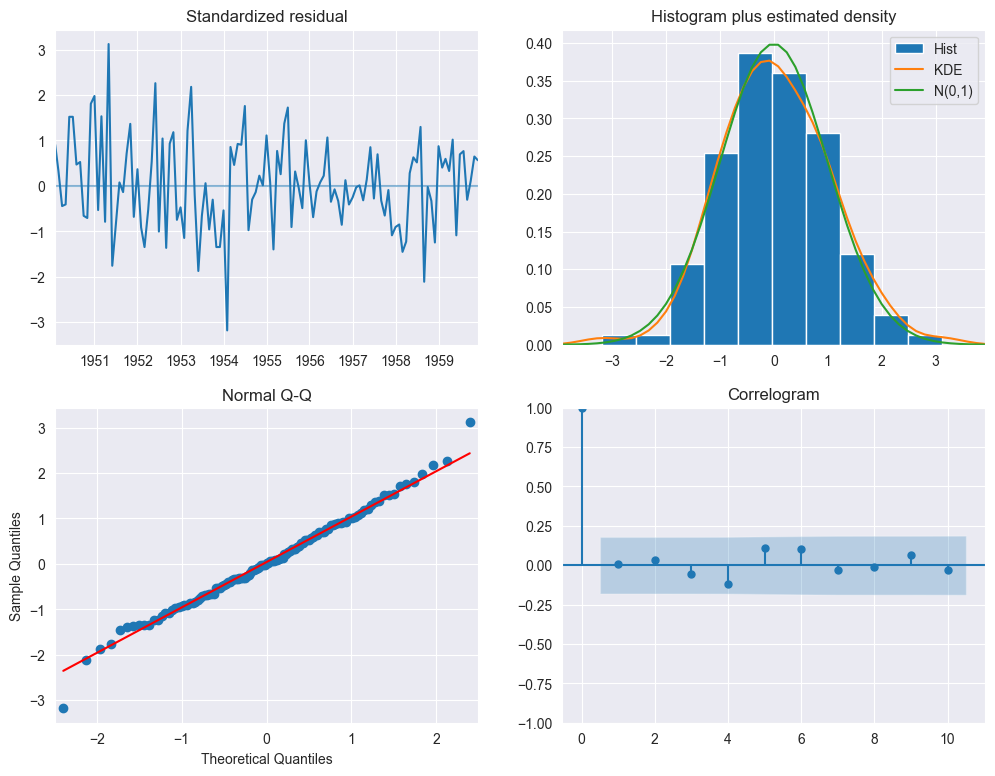

In [58]:
from pmdarima.arima import ARIMA

model = ARIMA(
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12), # 12 for monthly data
    suppress_warnings = True)

model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9));

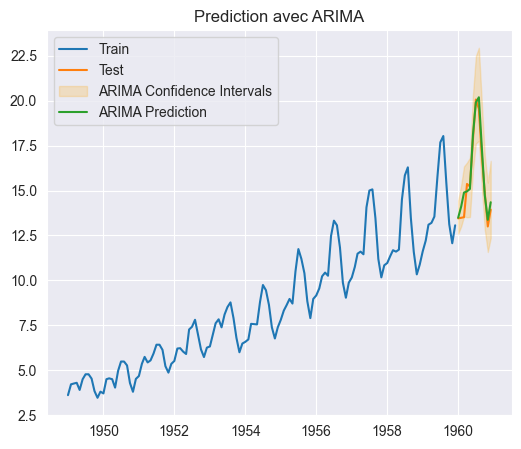

In [59]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

In [60]:
mean_absolute_percentage_error(test, np.exp(y_pred))
find_model_rmse(test, np.exp(y_pred))

MAPE 2.7755773360258207
RMSE --> 0.5364302774452312
RMSE/MEAN --> 0.034381230979528665


(0.5364302774452312, 0.034381230979528665)

In [61]:
def evaluate_model(data, p=1,q=1,d=1,P=1,Q=1,D=1,S=12):
    print("----------------------------------------------------")
    print("------------------ EVALUATE MODEL ------------------\n")
    print(f"p --> {p}")
    print(f"q --> {q}")
    print(f"d --> {d}")
    print(f"P --> {P}")
    print(f"Q --> {Q}")
    print(f"D --> {D}")
    print("\n")
    
    train, test = ts_train_test_split(data, '1960-01-01')
    
    model = ARIMA(
        order=(p, d, q),
        seasonal_order=(P, D, Q, S), # 12 for monthly data
        suppress_warnings = True
    )

    model.fit(np.log(train))
    y_pred, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
    
    MAPE = mean_absolute_percentage_error(test, np.exp(y_pred))
    RMSE, RMSE_MEAN = find_model_rmse(test, np.exp(y_pred))
    print("\n")
    
    return MAPE, RMSE, RMSE_MEAN
    
    

In [62]:
R = 3
test_number = 0

param_tested = []
MAPE_LIST = []
RMSE_LIST = []
RMSE_MEAN_LIST = []

for p in range(R):
    for q in range(R):
        for d in range(R):
            for P in range(R):
                for Q in range(R):
                    for D in range(R):
                        
                        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
                        print(f"Testing --> {test_number} / {3*3*3*3*3*3}")
                        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
                        
                        param = {
                            "p" : p,
                            "q" : q,
                            "d" : d,
                            "P" : P,
                            "Q" : Q,
                            "D" : D,
                        }
                        
                        MAPE, RMSE, RMSE_MEAN = evaluate_model(df["Passengers"], p, q, d, P, Q, D)
                        
                        param_tested.append(param)
                        MAPE_LIST.append(MAPE)
                        RMSE_LIST.append(RMSE)
                        RMSE_MEAN_LIST.append(RMSE_MEAN)
                        
                        test_number += 1

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 0 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 0
P --> 0
Q --> 0
D --> 0


MAPE 48.14759551913731
RMSE --> 246.26349543016792
RMSE/MEAN --> 15.78367678747432


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 1 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 0
P --> 0
Q --> 0
D --> 1


MAPE 2.965564216502356
RMSE --> 17.620519443348307
RMSE/MEAN --> 1.1293455541813389


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°

MAPE 4.642936062819811
RMSE --> 26.579782760726054
RMSE/MEAN --> 1.7035683646240847


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 18 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 0
P --> 2
Q --> 0
D --> 0


MAPE 5.788769412327407
RMSE --> 31.03358039269756
RMSE/MEAN --> 1.9890239989521155


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 19 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 0
P --> 2
Q --> 0
D --> 1


MAPE 3.9103678862917954
RMSE --> 23.417149981074363
RMSE/MEAN --> 1.500866890

MAPE 3.0951478208287897
RMSE --> 18.42762409166189
RMSE/MEAN --> 1.1810750193235329


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 36 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 1
P --> 1
Q --> 0
D --> 0


MAPE 6.514249543427504
RMSE --> 33.900482920040844
RMSE/MEAN --> 2.1727713415850034


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 37 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 1
P --> 1
Q --> 0
D --> 1


MAPE 3.6579305477723283
RMSE --> 21.73699973684499
RMSE/MEAN --> 1.393181630

MAPE 3.7368381609875434
RMSE --> 22.46255092659215
RMSE/MEAN --> 1.4396841197604475


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 54 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 2
P --> 0
Q --> 0
D --> 0


MAPE 97.29086886184851
RMSE --> 576.5608684174464
RMSE/MEAN --> 36.95330637417599


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 55 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 2
P --> 0
Q --> 0
D --> 1


MAPE 30.832361726511287
RMSE --> 164.28821445025713
RMSE/MEAN --> 10.529664871

MAPE 23.676317049325938
RMSE --> 131.16459134755746
RMSE/MEAN --> 8.406684523724119


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 72 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 2
P --> 2
Q --> 0
D --> 0


MAPE 26.40624692169718
RMSE --> 143.08476273685133
RMSE/MEAN --> 9.170679740032028


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 73 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 0
d --> 2
P --> 2
Q --> 0
D --> 1


MAPE 13.85330507184905
RMSE --> 73.77374090382168
RMSE/MEAN --> 4.72835358644

MAPE 2.558664356060792
RMSE --> 14.459721405685954
RMSE/MEAN --> 0.9267616733272132


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 90 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 0
P --> 1
Q --> 0
D --> 0


MAPE 12.192569882131123
RMSE --> 62.39243969589804
RMSE/MEAN --> 3.9988959809972666


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 91 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 0
P --> 1
Q --> 0
D --> 1


MAPE 2.5283282470947883
RMSE --> 16.905748649562995
RMSE/MEAN --> 1.08353400

MAPE 4.258875228717431
RMSE --> 23.140548244323323
RMSE/MEAN --> 1.4831387556460893


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 108 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 1
P --> 0
Q --> 0
D --> 0


MAPE 11.259570968855256
RMSE --> 78.72034357729736
RMSE/MEAN --> 5.045394395351307


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 109 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 1
P --> 0
Q --> 0
D --> 1


MAPE 7.56019165342192
RMSE --> 40.077089019428925
RMSE/MEAN --> 2.568646313

MAPE 2.441304342830809
RMSE --> 14.662028974629306
RMSE/MEAN --> 0.9397280988799886


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 126 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 1
P --> 2
Q --> 0
D --> 0


MAPE 2.380241975892873
RMSE --> 14.987709448188344
RMSE/MEAN --> 0.9606018192081608


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 127 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 1
P --> 2
Q --> 0
D --> 1


MAPE 2.616071892005677
RMSE --> 17.092890282766813
RMSE/MEAN --> 1.0955284

MAPE 8.779214829598644
RMSE --> 49.46062543362778
RMSE/MEAN --> 3.170061905387373


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 144 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 2
P --> 1
Q --> 0
D --> 0


MAPE 7.572064755522136
RMSE --> 38.91606827571192
RMSE/MEAN --> 2.4942334324873476


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 145 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 1
d --> 2
P --> 1
Q --> 0
D --> 1


MAPE 5.75674923626803
RMSE --> 32.163645785828905
RMSE/MEAN --> 2.06145286983

MAPE 13.883936717875642
RMSE --> 76.12363478217463
RMSE/MEAN --> 4.878964481482765


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 162 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 0
P --> 0
Q --> 0
D --> 0


MAPE 44.266310030213866
RMSE --> 238.96447283726232
RMSE/MEAN --> 15.315863182905536


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 163 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 0
P --> 0
Q --> 0
D --> 1


MAPE 2.865498590915612
RMSE --> 17.38170318959076
RMSE/MEAN --> 1.11403919

MAPE 3.4737293258627298
RMSE --> 20.095823120858345
RMSE/MEAN --> 1.2879942939323092


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 180 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 0
P --> 2
Q --> 0
D --> 0


MAPE 9.202853418640084
RMSE --> 54.92703794120208
RMSE/MEAN --> 3.5204186972287603


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 181 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 0
P --> 2
Q --> 0
D --> 1


MAPE 4.209781815314501
RMSE --> 24.082124317921405
RMSE/MEAN --> 1.5434868

MAPE 2.428441384343182
RMSE --> 14.467051397579787
RMSE/MEAN --> 0.9272314718359405


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 198 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 1
P --> 1
Q --> 0
D --> 0


MAPE 5.515210705557623
RMSE --> 29.898990474622195
RMSE/MEAN --> 1.9163051393340989


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 199 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 1
P --> 1
Q --> 0
D --> 1


MAPE 2.421726823160263
RMSE --> 15.988853468995366
RMSE/MEAN --> 1.0247677

MAPE 2.2955914331296676
RMSE --> 15.525510125883809
RMSE/MEAN --> 0.9950708827532972


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 216 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 2
P --> 0
Q --> 0
D --> 0


MAPE 11.619044854213287
RMSE --> 85.6931598904702
RMSE/MEAN --> 5.49230057928776


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 217 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 2
P --> 0
Q --> 0
D --> 1


MAPE 6.874234296167141
RMSE --> 36.673605773091666
RMSE/MEAN --> 2.350508097

MAPE 14.562796719629345
RMSE --> 81.9857272625147
RMSE/MEAN --> 5.254681446136214


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 234 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 2
P --> 2
Q --> 0
D --> 0


MAPE 3.739805916847636
RMSE --> 21.981271184350522
RMSE/MEAN --> 1.4088376320070286


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 235 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 0
q --> 2
d --> 2
P --> 2
Q --> 0
D --> 1


MAPE 4.0892757237772495
RMSE --> 24.026802210442845
RMSE/MEAN --> 1.53994110

MAPE 2.1797522129032942
RMSE --> 13.65946274363139
RMSE/MEAN --> 0.8754709854963503


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 252 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 0
P --> 1
Q --> 0
D --> 0


MAPE 2.8241282943299804
RMSE --> 18.118574243184586
RMSE/MEAN --> 1.1612671996096813


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 253 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 0
P --> 1
Q --> 0
D --> 1


MAPE 2.7146184206581125
RMSE --> 17.63298518118065
RMSE/MEAN --> 1.130144

MAPE 2.2955924638906904
RMSE --> 14.879300039011179
RMSE/MEAN --> 0.9536535743122435


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 270 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 1
P --> 0
Q --> 0
D --> 0


MAPE 11.1895215236619
RMSE --> 80.38872651241151
RMSE/MEAN --> 5.1523254569752845


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 271 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 1
P --> 0
Q --> 0
D --> 1


MAPE 8.285881847462221
RMSE --> 43.355479024614496
RMSE/MEAN --> 2.77876697

MAPE 3.019521779797664
RMSE --> 18.17735710856858
RMSE/MEAN --> 1.1650347484550425


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 288 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 1
P --> 2
Q --> 0
D --> 0


MAPE 2.5544730416635075
RMSE --> 15.992169862999209
RMSE/MEAN --> 1.0249803358270917


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 289 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 1
P --> 2
Q --> 0
D --> 1


MAPE 2.94074779363739
RMSE --> 18.865705606910172
RMSE/MEAN --> 1.20915281

MAPE 22.882630067545197
RMSE --> 127.28066413060061
RMSE/MEAN --> 8.157753386969807


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 306 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 2
P --> 1
Q --> 0
D --> 0


MAPE 28.73036769754862
RMSE --> 153.00077326035506
RMSE/MEAN --> 9.806223001735459


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 307 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 0
d --> 2
P --> 1
Q --> 0
D --> 1


MAPE 20.152501718787548
RMSE --> 109.49505997409314
RMSE/MEAN --> 7.0178271

MAPE 31.15271879857601
RMSE --> 172.75169793427327
RMSE/MEAN --> 11.072111844750262


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 324 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 0
P --> 0
Q --> 0
D --> 0


MAPE 20.772711697580185
RMSE --> 135.03867364573375
RMSE/MEAN --> 8.65498467367399


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 325 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 0
P --> 0
Q --> 0
D --> 1


MAPE 3.7819423301867445
RMSE --> 22.75287459823269
RMSE/MEAN --> 1.45829172

MAPE 2.578333771116709
RMSE --> 15.659579959760116
RMSE/MEAN --> 1.003663771931442


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 342 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 0
P --> 2
Q --> 0
D --> 0


MAPE 3.2545862597847752
RMSE --> 18.88941892120323
RMSE/MEAN --> 1.2106726676427664


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 343 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 0
P --> 2
Q --> 0
D --> 1


MAPE 3.3546684212174154
RMSE --> 20.564999512998202
RMSE/MEAN --> 1.3180650

MAPE 2.20143050895913
RMSE --> 13.24688503828234
RMSE/MEAN --> 0.849027792445865


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 360 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 1
P --> 1
Q --> 0
D --> 0


MAPE 6.366404225921192
RMSE --> 33.36534784931498
RMSE/MEAN --> 2.1384731238194132


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 361 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 1
P --> 1
Q --> 0
D --> 1


MAPE 2.40400015380865
RMSE --> 15.834262142989436
RMSE/MEAN --> 1.014859613669

MAPE 2.206061761946204
RMSE --> 13.363661948569952
RMSE/MEAN --> 0.8565123325519816


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 378 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 2
P --> 0
Q --> 0
D --> 0


MAPE 11.691837762282582
RMSE --> 88.23343895666241
RMSE/MEAN --> 5.6551137630311645


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 379 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 2
P --> 0
Q --> 0
D --> 1


MAPE 7.762397423936611
RMSE --> 40.745249439931385
RMSE/MEAN --> 2.6114704

MAPE 12.917342758111747
RMSE --> 71.6334437482964
RMSE/MEAN --> 4.591176298061783


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 396 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 2
P --> 2
Q --> 0
D --> 0


MAPE 3.3319932118116102
RMSE --> 20.104649698049176
RMSE/MEAN --> 1.2885600125390253


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 397 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 1
d --> 2
P --> 2
Q --> 0
D --> 1


MAPE 2.7982947279201777
RMSE --> 18.314448653371592
RMSE/MEAN --> 1.1738213

MAPE 2.499045129566158
RMSE --> 15.24062932200291
RMSE/MEAN --> 0.97681212083831


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 414 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 0
P --> 1
Q --> 0
D --> 0


MAPE 2.5613772575613463
RMSE --> 16.671195229931723
RMSE/MEAN --> 1.0685008620968817


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 415 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 0
P --> 1
Q --> 0
D --> 1


MAPE 2.7844381698359593
RMSE --> 18.1415705566867
RMSE/MEAN --> 1.1627410939

MAPE 2.3458863856293797
RMSE --> 15.091468656482252
RMSE/MEAN --> 0.967252020467485


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 432 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 1
P --> 0
Q --> 0
D --> 0


MAPE 14.216447029609952
RMSE --> 76.3046101517523
RMSE/MEAN --> 4.890563670127911


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 433 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 1
P --> 0
Q --> 0
D --> 1


MAPE 8.080829155641156
RMSE --> 42.39736808535537
RMSE/MEAN --> 2.7173591170

MAPE 2.5303179876194766
RMSE --> 15.02804410363347
RMSE/MEAN --> 0.9631869736329689


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 450 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 1
P --> 2
Q --> 0
D --> 0


MAPE 2.299315163742044
RMSE --> 14.394811227156895
RMSE/MEAN --> 0.9226014088254432


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 451 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 1
P --> 2
Q --> 0
D --> 1


MAPE 2.6440150108436002
RMSE --> 17.33210150119033
RMSE/MEAN --> 1.1108600

MAPE 9.856600336360847
RMSE --> 54.89268722234008
RMSE/MEAN --> 3.5182170690784402


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 468 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 2
P --> 1
Q --> 0
D --> 0


MAPE 8.355152738790817
RMSE --> 42.75041565948012
RMSE/MEAN --> 2.7399868669969156


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 469 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 1
q --> 2
d --> 2
P --> 1
Q --> 0
D --> 1


MAPE 4.672882402000719
RMSE --> 26.628425003987438
RMSE/MEAN --> 1.706685974

MAPE 12.009972241125144
RMSE --> 66.53670770337423
RMSE/MEAN --> 4.264513045501344


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 486 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 0
P --> 0
Q --> 0
D --> 0


MAPE 21.233402582505743
RMSE --> 136.8832849858208
RMSE/MEAN --> 8.773210678464455


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 487 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 0
P --> 0
Q --> 0
D --> 1


MAPE 3.7998610256970244
RMSE --> 22.83913675626424
RMSE/MEAN --> 1.463820498

MAPE 2.182856393350337
RMSE --> 15.17202416704488
RMSE/MEAN --> 0.9724150355540269


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 504 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 0
P --> 2
Q --> 0
D --> 0


MAPE 2.4964671054172496
RMSE --> 15.736891341790468
RMSE/MEAN --> 1.0086188622659982


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 505 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 0
P --> 2
Q --> 0
D --> 1


MAPE 3.5783512546019547
RMSE --> 21.530246507965003
RMSE/MEAN --> 1.379930

MAPE 2.920740054088007
RMSE --> 17.848319923318645
RMSE/MEAN --> 1.1439458876233812


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 522 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 1
P --> 1
Q --> 0
D --> 0


MAPE 6.193197169171852
RMSE --> 32.72462067960644
RMSE/MEAN --> 2.097407229997158


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 523 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 1
P --> 1
Q --> 0
D --> 1


MAPE 2.6886711009854705
RMSE --> 17.678895125170598
RMSE/MEAN --> 1.13308700

MAPE 3.097494522693928
RMSE --> 18.52880313552524
RMSE/MEAN --> 1.1875598510409389


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 540 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 2
P --> 0
Q --> 0
D --> 0


MAPE 11.255216088255187
RMSE --> 81.76235349722495
RMSE/MEAN --> 5.240364832510731


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 541 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 2
P --> 0
Q --> 0
D --> 1


MAPE 26.951859989261507
RMSE --> 143.46891432110385
RMSE/MEAN --> 9.19530102

MAPE 18.215829019394782
RMSE --> 101.17708591725147
RMSE/MEAN --> 6.484706227477623


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 558 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 2
P --> 2
Q --> 0
D --> 0


MAPE 14.890920162884152
RMSE --> 81.06255724984865
RMSE/MEAN --> 5.195513045743143


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 559 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 2
P --> 2
Q --> 0
D --> 1


MAPE 13.84993559556135
RMSE --> 74.80686170430205
RMSE/MEAN --> 4.794569022

MAPE 2.1635523397034366
RMSE --> 13.405238502926759
RMSE/MEAN --> 0.859177083552768


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 576 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 0
P --> 1
Q --> 0
D --> 0


MAPE 2.8918901373798644
RMSE --> 17.77409351364821
RMSE/MEAN --> 1.13918852130205


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 577 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 0
P --> 1
Q --> 0
D --> 1


MAPE 2.623895934663212
RMSE --> 17.217887262926496
RMSE/MEAN --> 1.103539796

MAPE 2.178825233322087
RMSE --> 14.880884387227672
RMSE/MEAN --> 0.9537551193671623


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 594 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 1
P --> 0
Q --> 0
D --> 0


MAPE 15.630860816450578
RMSE --> 81.36753739431313
RMSE/MEAN --> 5.215060027395523


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 595 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 1
P --> 0
Q --> 0
D --> 1


MAPE 5.3703067670416
RMSE --> 29.625338463859517
RMSE/MEAN --> 1.8987660603

MAPE 2.8163111533445004
RMSE --> 16.981409446732442
RMSE/MEAN --> 1.0883833092468715


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 612 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 1
P --> 2
Q --> 0
D --> 0


MAPE 2.2788108885670715
RMSE --> 14.270107113120332
RMSE/MEAN --> 0.9146087933280335


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 613 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 1
P --> 2
Q --> 0
D --> 1


MAPE 2.471700302477354
RMSE --> 15.784246556675582
RMSE/MEAN --> 1.01165

MAPE 5.4507208474394195
RMSE --> 30.41213841623179
RMSE/MEAN --> 1.9491941440173783


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 630 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 2
P --> 1
Q --> 0
D --> 0


MAPE 8.698289683950865
RMSE --> 45.0691222182911
RMSE/MEAN --> 2.888598884483881


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 631 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 1
d --> 2
P --> 1
Q --> 0
D --> 1


MAPE 3.6232225675430767
RMSE --> 21.767536461302722
RMSE/MEAN --> 1.395138810

MAPE 8.383751600722473
RMSE --> 47.861022786766775
RMSE/MEAN --> 3.0675391538023664


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 648 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 0
P --> 0
Q --> 0
D --> 0


MAPE 19.742889843480533
RMSE --> 130.88794207930007
RMSE/MEAN --> 8.388953342632748


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 649 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 0
P --> 0
Q --> 0
D --> 1


MAPE 3.711356307619414
RMSE --> 22.366079519536733
RMSE/MEAN --> 1.4335010

MAPE 2.17163688370524
RMSE --> 15.870789247910366
RMSE/MEAN --> 1.0172007321408831


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 666 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 0
P --> 2
Q --> 0
D --> 0


MAPE 3.273014280001587
RMSE --> 18.721384137100777
RMSE/MEAN --> 1.1999028752433962


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 667 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 0
P --> 2
Q --> 0
D --> 1


MAPE 3.6428954559450584
RMSE --> 21.804485051239386
RMSE/MEAN --> 1.3975069

MAPE 2.359137123275708
RMSE --> 13.9967645866411
RMSE/MEAN --> 0.8970895500366816


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 684 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 1
P --> 1
Q --> 0
D --> 0


MAPE 3.252518911985325
RMSE --> 19.296954751992104
RMSE/MEAN --> 1.2367927136579113


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 685 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 1
P --> 1
Q --> 0
D --> 1


MAPE 2.3324856181644464
RMSE --> 15.223385153001427
RMSE/MEAN --> 0.97570689

MAPE 2.5318787030821825
RMSE --> 16.19577704557977
RMSE/MEAN --> 1.0380300570447911


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 702 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 2
P --> 0
Q --> 0
D --> 0


MAPE 11.770112333900178
RMSE --> 87.29967950295435
RMSE/MEAN --> 5.5952666574387075


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 703 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 2
P --> 0
Q --> 0
D --> 1


MAPE 8.030616727741902
RMSE --> 41.9425401112985
RMSE/MEAN --> 2.688207992

MAPE 10.550509505268952
RMSE --> 59.03114401122027
RMSE/MEAN --> 3.7834616772592593


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 720 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 2
P --> 2
Q --> 0
D --> 0


MAPE 2.673112490706658
RMSE --> 16.122142108527783
RMSE/MEAN --> 1.0333105997632137


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Testing --> 721 / 729
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 2
d --> 2
P --> 2
Q --> 0
D --> 1


MAPE 2.403426866417703
RMSE --> 15.701390217431163
RMSE/MEAN --> 1.0063435

In [63]:
def find_best_model(criteria_list, rmse_list, models_list):
    

    sorted_list = sorted(criteria_list)
    smallest_values = sorted_list[:3]

    indices = []
    for value in smallest_values:
        index = criteria_list.index(value)
        indices.append(index)
    
    print("Indices of the three smallest values:", indices)
    print("")
    
    for indice in indices:
        model = models_list[indice]
        criteria = criteria_list[indice]
        rmse = rmse_list[indice]
        print("MODEL", model)
        print("MAPE -->", criteria)
        print("RMSE -->", rmse)


In [64]:
find_best_model(MAPE_LIST, RMSE_LIST, param_tested)

Indices of the three smallest values: [510, 500, 591]

MODEL {'p': 2, 'q': 0, 'd': 0, 'P': 2, 'Q': 2, 'D': 0}
MAPE --> 2.0992867329560903
RMSE --> 14.476045473027161
MODEL {'p': 2, 'q': 0, 'd': 0, 'P': 1, 'Q': 1, 'D': 2}
MAPE --> 2.1005042648298984
RMSE --> 15.335856811935932
MODEL {'p': 2, 'q': 1, 'd': 0, 'P': 2, 'Q': 2, 'D': 0}
MAPE --> 2.1257308594638347
RMSE --> 15.051176092812627


**Conclusions?**

In [65]:
evaluate_model(df["Passengers"], 2,0,0,2,2,0,S=12)

----------------------------------------------------
------------------ EVALUATE MODEL ------------------

p --> 2
q --> 0
d --> 0
P --> 2
Q --> 2
D --> 0


MAPE 2.0992867329560903
RMSE --> 14.476045473027161
RMSE/MEAN --> 0.9278079258475899




(2.0992867329560903, 14.476045473027161, 0.9278079258475899)

##### What about Metrics?

https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

#### Automatize the analysis

**TODO - Write a class with the following methods:**
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Bonus:** 
* Add a method get_cv Which performs cross validation
* To further automatize the process add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit: such as a log transformation.

In [67]:
# Write your code here

**TODO - Test this method on all the other [11 datasets] of pmdarima**

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [68]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [69]:
#### Write your code here

#### Want some more?

**data**: 
- choose your poison: https://data.world/datasets/time-series